### Import modules and connect to database

In [11]:
from sqlalchemy import create_engine
import yaml

In [3]:
cred = yaml.load(open('/Users/vivianemarani/.ssh/qpx_express_cred.yml'))
conn = 'postgresql://{user}:{password}@{host}/{dbname}'.format(**cred['rds'])

In [5]:
engine = create_engine(conn)

In [7]:
engine.table_names()

['trips', 'airport', 'city', 'aircraft', 'carrier']

------

## Preprocessing
Get TRIPS table ready for Modeling

In [176]:
%matplotlib inline

# Import packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn.preprocessing as pps

In [128]:
trips = pd.read_sql("SELECT * from trips", engine)
trips.head()

,id,duration,price,n_segments,origin_airport,dest_airport,origin_aircraft,dest_aircraft,origin_carrier,dest_carrier
0,1,2041,"$1,678.46",4,SFO,GRU,319,773,UA,JJ
1,2,2118,"$1,721.36",4,SFO,GRU,738,738,CM,CM
2,3,2100,"$1,721.36",4,SFO,GRU,738,738,CM,CM
3,4,2115,"$1,721.36",4,SFO,GRU,738,738,CM,CM
4,5,2103,"$1,721.36",4,SFO,GRU,738,738,CM,CM


In [131]:
# convert duration column to integer value
trips['duration'] = pd.to_numeric(trips['duration'])
trips[['price']] = trips[['price']].replace('[\$,]','',regex=True).astype(float)

In [132]:
# Separate origin aircraft models with get_dummies
trips["319"] = pd.get_dummies(trips['origin_aircraft']).ix[:,0]
trips["738"] = pd.get_dummies(trips['origin_aircraft']).ix[:,1]
trips["753"] = pd.get_dummies(trips['origin_aircraft']).ix[:,2]
trips["7S8"] = pd.get_dummies(trips['origin_aircraft']).ix[:,3]

In [133]:
# Separate destination aircraft models with get_dummies
trips["738"] = pd.get_dummies(trips['dest_aircraft']).ix[:,0]
trips["763"] = pd.get_dummies(trips['dest_aircraft']).ix[:,1]
trips["764"] = pd.get_dummies(trips['dest_aircraft']).ix[:,2]
trips["773"] = pd.get_dummies(trips['dest_aircraft']).ix[:,3]
trips["777"] = pd.get_dummies(trips['dest_aircraft']).ix[:,4]

In [134]:
# Separate origin carrier models with get_dummies
trips["AM"] = pd.get_dummies(trips['origin_carrier']).ix[:,0]
trips["CM"] = pd.get_dummies(trips['origin_carrier']).ix[:,1]
trips["UA"] = pd.get_dummies(trips['origin_carrier']).ix[:,2]

In [135]:
# Separate detination carrier models with get_dummies
trips["CM"] = pd.get_dummies(trips['dest_carrier']).ix[:,0]
trips["JJ"] = pd.get_dummies(trips['dest_carrier']).ix[:,1]
trips["UA"] = pd.get_dummies(trips['dest_carrier']).ix[:,2]

In [136]:
#trips.drop(trips.ix[1]["origin_airport", "dest_airport","dest_aircraft","origin_carrier", "dest_carrier"])

In [137]:
# Delete unnecessary tables
del trips['origin_aircraft']
del trips['dest_aircraft']
del trips['origin_carrier']
del trips['dest_carrier']
del trips['origin_airport']
del trips['dest_airport']
del trips['n_segments']
del trips['id']

In [175]:
y = trips["price"].values
del trips["price"]
X = trips

## Look for NaN and Outliers in Normalized Data

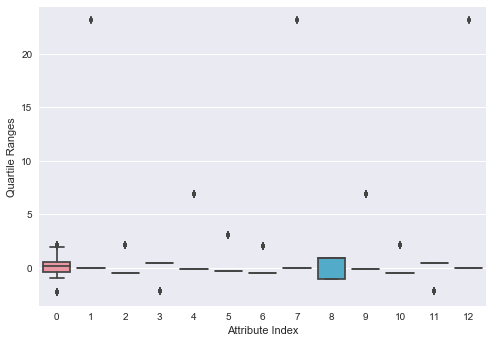

In [181]:
data = pps.scale(X) # centers 
ax = sns.boxplot(data=data)
plt.xlabel("Attribute Index");
plt.ylabel(("Quartile Ranges"));

In [16]:
import psycopg2
import yaml
from os.path import expanduser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


In [17]:
def main():
    creds = yaml.load(open(expanduser('~/.ssh/qpx_express_cred.yml')))
    df = _get_data(creds)
    create_error_plot(df, 100, 5)
    print("Plot Creation Completed.")


def create_error_plot(df, max_trees, incr):
    ''' for RF Regressor, oob_scores is R^2 '''

    models, oob_scores, test_errors = build_amazon(df, max_trees, incr)

    fig = plt.figure(num=1, figsize=(10, 10))
    ax = fig.add_subplot(111)

    ax.set_xlim([0, max(models.keys())*1.1])
    ax.set_ylim([min(test_errors.values())*0.9, max(test_errors.values())*1.1])
    ax.set_xlabel("Number of Trees")
    ax.set_ylabel("Test MSE")

    x1 = np.array(list(models.keys()))
    y1 = np.array([test_errors[k] for k in x1])
    idx = np.argsort(x1)
    x1 = x1[idx]
    y1 = y1[idx]

    ax.plot(x1, y1)

    fig.savefig("../rf_plots.jpg")


def build_amazon(df, max_trees, incr):

    iterator = [incr*i for i in range(1, int(max_trees/incr))]

    X, y = _transform(df)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    oob_scores, models, test_errors = {}, {}, {}

    for n_trees in iterator:
        models[n_trees] = _spawn_one_forest(X_train, y_train, n_trees)
        oob_scores[n_trees] = models[n_trees].oob_score_
        mse = mean_squared_error(y_test, models[n_trees].predict(X_test))
        test_errors[n_trees] = mse

    return models, oob_scores, test_errors


def _spawn_one_forest(X, y, n_trees):

    model = RandomForestRegressor(n_estimators=n_trees,
        oob_score=True, random_state=1)

    model.fit(X, y)

    return model


def _transform(df):
    y = df.pop('price').apply(lambda x: float(x[1:].replace(",","")))
    X = df['duration']

    for col in ['origin_aircraft', 'dest_aircraft', 'origin_carrier', 'dest_carrier']:
        dums = pd.get_dummies(df[col])
        X = pd.concat([X, dums], axis=1)

    return X, y


def _get_data(creds):

    query = '''SELECT * FROM trips'''
    _, cur = _connect_DB(creds)

    cur.execute(query)

    columns = [x[0] for x in cur.description]
    data = np.array([row for row in cur])
    df = pd.DataFrame(data=data, columns=columns)

    return df


def _connect_DB(credentials):

    try:
        conn = psycopg2.connect(**credentials['rds'])
        cur = conn.cursor()
        print("Connection Established")
    except:
        print("Error Establishing Connection")
        return None, None

    return conn, cur


